In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch

In [2]:
def quat_conjugate(q):
    return np.array([q[0], -q[1], -q[2], -q[3]])

    
def quat_inverse(q):
    q_norm = q/np.linalg.norm(q)
    return quat_conjugate(q_norm)


def quat_left_multiply(l,r):
    q = np.zeros(4)
    q[0] = l[0]*r[0] - l[1]*r[1] - l[2]*r[2] - l[3]*r[3]
    q[1] = l[0]*r[1] + l[1]*r[0] + l[2]*r[3] - l[3]*r[2]
    q[2] = l[0]*r[2] + l[2]*r[0] + l[3]*r[1] - l[1]*r[3]
    q[3] = l[0]*r[3] + l[3]*r[0] + l[1]*r[2] - l[2]*r[1]
    return q

In [3]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def pyplot_skeleton(topology, rel_positions, ax=None, show=True, color='black'):
    # Plot a skeleton in 3d
    if ax is None:
        plt.figure(figsize=(10, 10))
        ax = plt.axes(projection='3d')

    positions = torch.zeros_like(rel_positions)
    for j, i in enumerate(topology):
        positions[j] = rel_positions[j] + positions[i]
        ax.plot(
            np.array(positions[[i,j], 0]), 
            np.array(positions[[i,j], 1]), 
            np.array(positions[[i,j], 2]), 
            color=color
        )
    
    ax.scatter(
        np.array(positions[:, 0]), 
        np.array(positions[:, 1]), 
        np.array(positions[:, 2]), 
        color=color,
        marker='o'
    )
    if show:
        set_axes_equal(ax)
        plt.show()
    else:
        return ax

In [4]:
def find_rotations(topology, positions):
    # Find the rotations (in quaternions) for each squeleton joint
    # NB: for convention, we choose to set to 0 the Euler angle gamma

    euler = np.zeros((len(topology), 2))
    quater = np.zeros((len(topology), 4))
    quater[0] = np.array([1., 0., 0., 0.])
    rel_quater = np.zeros_like(quater)
    rel_quater[0] = np.array([1., 0., 0., 0.])

    for j in range(len(topology)):

        if j == 0 or j == 9:
            quater[j] = np.array([1., 0., 0., 0.])
            rel_quater[j] = np.array([1., 0., 0., 0.])
            continue

        # Get the quaternion of its parent
        q_parent = quater[topology[j]]

        # Initialize a quaternion encoding the relative position of the joint
        q_delta = np.zeros(4)

        # Get the relative position of the joint
        q_delta[1:] = positions[j] - positions[topology[j]]
        
        # Normalize to obtain a unitary vector
        q_delta /= np.linalg.norm(q_delta)

        # Express this vector in the relative coordinate system of the parent joint
        q_delta = quat_left_multiply(quat_inverse(q_parent), quat_left_multiply(q_delta, q_parent))

        # Compute the euler angles with gamma=0
        alpha = np.arctan2(q_delta[1], -q_delta[2])
        beta = np.arccos(q_delta[3])
        euler[j] = np.array([alpha, beta])
        
        # Compute the corresponding relative quaternion
        rel_quater[j] = np.array([
            np.cos(alpha/2)*np.cos(beta/2),
            np.cos(alpha/2)*np.sin(beta/2),
            np.sin(alpha/2)*np.sin(beta/2),
            np.sin(alpha/2)*np.cos(beta/2)
        ])
        
        # Compute the corresponding absolute quaternion
        quater[j] = quat_left_multiply(q_parent, rel_quater[j])

    return euler, quater, rel_quater


def rotate_vector(vector, quaternion):
    # Apply the rotation defined by the quaternion input onto the vector

    q_vector = np.zeros(4)
    q_vector[1:] = vector
    return quat_left_multiply(quaternion, quat_left_multiply(q_vector, quat_inverse(quaternion)))[1:]


def forward_kinematics(base_position, topology, offsets, quaternions):
    # Compute the joint positions based on topology, lengths and rotations

    positions = np.zeros((offsets.shape[0]+1, 3))
    rel_positions = np.zeros((offsets.shape[0]+1, 3))
    positions[0] = base_position
    rel_positions[0] = base_position

    for i, offset in enumerate(offsets):
        rel_positions[i+1] = offset * rotate_vector(np.array([0., 0., 1.]), quaternions[i+1])
        positions[i+1] = positions[topology[i+1]] + rel_positions[i+1]

    return rel_positions, positions
    

In [5]:
# topology = [0, 0, 1, 2, 3, 1, 5, 6, 5, 8, 9]
topology = [0, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 12, 13, 12, 15, 16, 17, 12, 19, 20, 21]
# positions = np.array([
#     [1., 1., 1.],
#     [2., 1., 2.],
#     [2., -1., 4.],
#     [3., 5., 4.],
#     [3., 8., -2.],
#     [1., 7., -4.],
#     [4., 0., 1.],
#     [-5., 0., 1.],
#     [-7., 0., 4.],
#     [-8., 1., 7.],
#     [-3., 2., 1.],
# ])
positions = np.array([[ 0.316029 , -0.544247 ,  3.07123  ],
       [ 0.237137 , -0.537903 ,  3.049758 ],
       [ 0.065891 , -0.608917 ,  2.768026 ],
       [ 0.092609 , -1.030478 ,  2.851481 ],
       [ 0.054801 , -1.087159 ,  2.808301 ],
       [ 0.389443 , -0.540329 ,  3.035292 ],
       [ 0.464061 , -0.599492 ,  2.695029 ],
       [ 0.446056 , -1.050501 ,  2.839232 ],
       [ 0.481595 , -1.090708 ,  2.759482 ],
       [ 0.316029 , -0.544247 ,  3.07123  ],
       [ 0.319947 , -0.306758 ,  3.04533  ],
       [ 0.3199685, -0.21826  ,  3.0328275],
       [ 0.31999  , -0.129762 ,  3.020325 ],
       [ 0.319473 , -0.071174 ,  3.009537 ],
       [ 0.315336 ,  0.070742 ,  2.95804  ],
       [ 0.157047 , -0.145856 ,  3.023532 ],
       [ 0.088504 , -0.389205 ,  2.937053 ],
       [ 0.104957 , -0.453951 ,  2.74061  ],
       [ 0.105083 , -0.48804  ,  2.624913 ],
       [ 0.486067 , -0.145082 ,  2.993604 ],
       [ 0.506708 , -0.389895 ,  2.866807 ],
       [ 0.426338 , -0.491043 ,  2.705701 ],
       [ 0.4363   , -0.519555 ,  2.614676 ]])
rel_positions = positions.copy()
rel_positions[1:] -= positions[topology[1:]]
base_position = positions[0]
offsets = np.linalg.norm(rel_positions[1:], axis=1)
print(offsets)

[0.08200757 0.33725525 0.43057202 0.08066408 0.08183218 0.35333697
 0.47384365 0.09612328 0.         0.23892925 0.08937678 0.08937678
 0.05957518 0.15102717 0.16376728 0.26719936 0.2074912  0.12061456
 0.1689091  0.2764723  0.20650762 0.09590478]


In [7]:
euler, quater, rel_quater = find_rotations(topology, positions)
print(quater)
print(euler)

[[ 1.          0.          0.          0.        ]
 [ 0.41200802  0.53867605 -0.58373184 -0.44646908]
 [ 0.27713844  0.58341206 -0.75981183 -0.07423368]
 [ 0.1850309   0.19073595 -0.60556422  0.75011689]
 [-0.37095357 -0.87139095 -0.09127456  0.307799  ]
 [ 0.36432973  0.58362444  0.61560219  0.38429196]
 [ 0.1359614   0.6375188   0.75833309  0.00390011]
 [ 0.0733161   0.07693012  0.58473814 -0.80423119]
 [-0.21835977 -0.95646726  0.00149215 -0.19361602]
 [ 1.          0.          0.          0.        ]
 [ 0.00550702  0.00614016  0.74442088  0.66765974]
 [-0.1530175   0.17633274  0.73406364  0.63768565]
 [-0.65552701  0.75465066  0.02109621  0.01848459]
 [-0.07049254  0.07791407  0.76450668  0.63599508]
 [-0.0429046   0.03738292  0.81798026  0.57242467]
 [-0.70896645  0.01422729  0.70000447 -0.08460442]
 [-0.48789896 -0.53696479  0.61114129 -0.31643283]
 [-0.14823353 -0.97024742  0.17887604 -0.06819177]
 [-0.11871056 -0.82088076 -0.55296416  0.07932987]
 [-0.64389106  0.02337288 -0.76

In [34]:
rel_fk_positions, fk_positions = forward_kinematics(base_position, topology, offsets, quater)

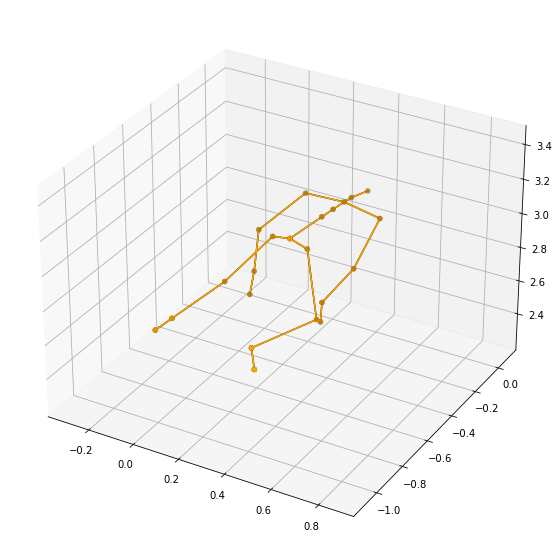

In [35]:
ax = pyplot_skeleton(topology, torch.Tensor(rel_positions), show=False, color='black')
pyplot_skeleton(topology, torch.Tensor(rel_fk_positions), ax=ax, color='orange')